In [1]:
import numpy as np
import pymc3 as pm

import aesara.tensor as at
from aesara.tensor.random.op import RandomVariable

from scipy import stats as st

import aesara

%config InlineBackend.figure_format = "retina"
%matplotlib inline

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


In [2]:
K = 50; N = 300
M = 2; mu = 2.
rng = np.random.RandomState(seed=34)

In [3]:
def generate_weights(M, rng, K):

    betas = rng.beta(1., M, size=(K-1,))
    
    sticks = np.concatenate(([1], np.cumprod(1 - betas[:-1])))

    product = betas * sticks
    
    return np.append(product, 1 - product.sum()) # shape = (K,)


def stick_glueing(weights):
    
    denominator = np.concatenate(([1], -weights[:-1]))
    denominator = np.cumsum(denominator)
    
    return weights[:-1]/denominator[:-1] # shape = (K - 1,)


def create_dp_samples(M, rng, K):
    
    atoms = rng.normal(loc=mu, scale=3., size=(K,))
    weights = generate_weights(M, rng, K)

    return rng.choice(a=atoms, p=weights, size=(K,))

In [4]:
class DirichletProcess:
    
    def __init__(self, M, rng, K):
        self.M = M
        self.K = K
        
        self.samples = create_dp_samples(M, rng, K)
        self.rng = rng
    
    def run(self):
        
        atoms, counts = np.unique(self.samples, return_counts=True)
        
        weights = np.array(counts)/counts.sum() # empirical weights
        
        recovered_betas = stick_glueing(weights)
        
        with pm.Model(rng_seeder=rng) as model:
            α = pm.Uniform("α", 0., 10.)
            
            # K - 1 because the Kth weight is 1 - weights.sum()
            β = pm.Beta("β", 1., α, observed=recovered_betas)
            µ = pm.Normal("µ", mu=0., sigma=5.)
            
            G0 = pm.Normal("G0", mu=µ, sigma=3., observed=atoms)
            
            self.posterior = pm.sample(draws=2000, chains=1)

In [5]:
dp = DirichletProcess(M, rng, K)
dp.run()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, µ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


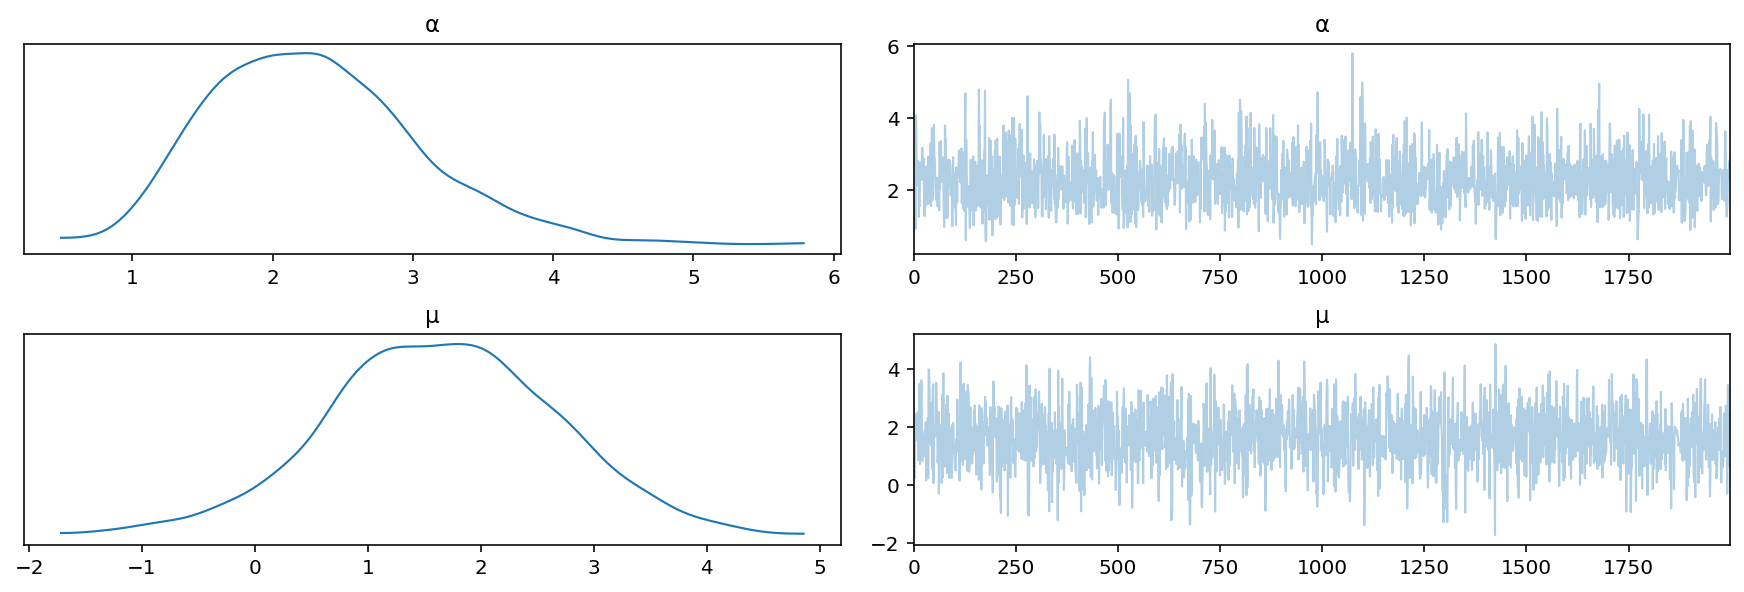

In [6]:
_ = pm.plot_trace(dp.posterior)

In [7]:
dp.posterior.to_dict()["posterior"]["α"].mean()

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


2.287184861521955

Atoms are denoted by $\theta_h$ whereas samples are denoted by $x_h$ (for $h = 1, \dots, K$).

\begin{align*}
    \theta_h &\stackrel{\text{i.i.d.}}{\sim} G_0\\
    v_h &\stackrel{\text{i.i.d.}}{\sim} \text{Beta}(1, \alpha)\\
    w_h &= v_h \prod_{\ell < h} (1 - v_h)\\
    x_h &\stackrel{\text{i.i.d.}}{\sim} \text{Categorical}(w_1, \dots, w_K)
\end{align*}

where $P(x = \theta_h) = w_h$.